# Needed for consistently measuring RVs.
To consistently measure the RVs of my target stars, I need to align them with the telluric lines. That is because I took no effort to make sure they are consistent by e.g. observing an RV standard or something. I have a decent amount of code already written for the IGRINS pipeline, so lets just re-use that.

## Status as of end of day Thusday, Sep 3:
  - Seems to work. Need to go through and apply to all of my stars I guess?
  - How stable is the rv fit?
  - Is it the same for all echi files that go into the final ones?
  - Need to keep track of the velocity changes to include in the companion velocities (or just re-run the ccf analysis on the new files)

In [8]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import HelperFunctions
import telfit
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import FittingUtilities
from scipy.optimize import minimize
from functools import partial
import Telluric_Wavecal
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
home = os.environ['HOME']
#sys.path.append('{}/School/Research/IGRINS_data/plp/recipes/'.format(home))
#import recipe_tell_wvsol

%matplotlib inline

In [ ]:
with open('../starlist_20151016', 'r') as f:
    fnames = ['../{}'.format(fn).strip() for fn in f.readlines()]

In [ ]:
fname = fnames[0]
o2_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(690, 765))
h2o_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(700., 715., 725., 735.))

print('O2 Fit:\n================')
o2_rv, o2_rv_err = o2_fitter.fit()
print('\n\nH2O Fit:\n===============')
h2o_rv, h2o_rv_err = h2o_fitter.fit()

In [7]:
print(o2_rv, o2_rv_err)
print(h2o_rv, h2o_rv_err)

(-0.15427331607709174, 0.0045378657711410419)
(0.04757441906822106, 0.0035891945638753826)


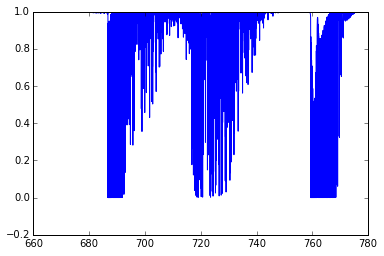

In [12]:
import telfit
modeler = telfit.Modeler()
full_model = modeler.MakeModel(highfreq=1e7/680.0, lowfreq=1e7/780.0)
plt.plot(full_model.x, full_model.y)

In [ ]:
with open('telluric_wavecal_summary.csv', 'w') as f:
    f.write('filename,o2_rv,o2_rv_err,h2o_rv,h2o_rv_err\n')

for i, fname in enumerate(fnames):
    print('File {}/{}: {}'.format(i+1, len(fnames), fname))
    o2_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(690, 765), telluric_model=full_model)
    h2o_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(700., 715., 725., 735.), telluric_model=full_model)
    
    print('O2 Fit:\n================')
    o2_rv, o2_rv_err = o2_fitter.fit()
    print('\n\nH2O Fit:\n===============')
    h2o_rv, h2o_rv_err = h2o_fitter.fit()
    
    with open('telluric_wavecal_summary.csv', 'a') as f:
        f.write('{},{},{},{},{}\n'.format(fname, o2_rv, o2_rv_err, h2o_rv, h2o_rv_err))

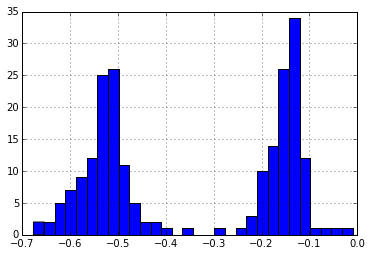

In [15]:
import pandas as pd
df = pd.read_csv('telluric_wavecal_summary.csv')
df.o2_rv.hist(bins=30)

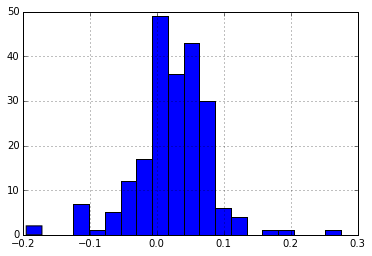

In [17]:
df.h2o_rv.hist(bins=20)

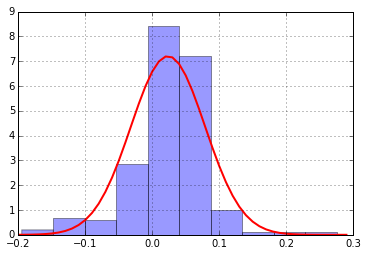

In [25]:
import scipy.stats
values = df.h2o_rv
loc, scale = scipy.stats.norm.fit(data=values[~np.isnan(values)])
df.h2o_rv.hist(bins=10, normed=True, alpha=0.4)
x = np.arange(-0.2, 0.3, 0.01)
y = scipy.stats.norm.pdf(x, loc=loc, scale=scale)
plt.plot(x, y, 'r-', lw=2)

In [23]:
y

array([ 0.00208537])